In [1]:
import re
import glob
import os
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dispatch_dfs = []
rays_dfs = []

In [3]:
# Process Swift DispatchBenchmark files
for file in glob.glob('benchmark-results/Current_run.DispatchBenchmark.*.wallClock.histogram.samples.tsv'):
    # Extract Class count and version from filename
    base = os.path.basename(file)
    # Example file name:
    # Current_run.DispatchBenchmark.dispatchExistential(classCount:14).wallClock.histogram.samples.tsv
    m = re.search(r'DispatchBenchmark.dispatch([A-Za-z]+)\(classCount:([0-9]+)\)', base)

    # Read the TSV file into a DataFrame
    df = pd.read_csv(file, sep='\t').rename(columns={'Time (wall clock) (μs)': 'Time (μs)'})

    # Add params columns
    df['Class count'] = int(m.group(2))
    df['version'] = "Swift " + m.group(1)

    # Append to the list of DataFrames
    dispatch_dfs.append(df)

In [4]:
# Process Swift RaysBenchmark files
for file in glob.glob('benchmark-results/Current_run.RaysBenchmark.*.wallClock.histogram.samples.tsv'):
    # Extract Class count and version from filename
    base = os.path.basename(file)
    # Example file name:
    # Current_run.RaysBenchmark.runExistential(shapeCount:1000).wallClock.histogram.samples.tsv
    m = re.search(r'RaysBenchmark.run([A-Za-z]+)\(shapeCount:([0-9]+)\)', base)

    # Read the TSV file into a DataFrame
    df = pd.read_csv(file, sep='\t').rename(columns={'Time (wall clock) (μs)': 'Time (μs)'})

    # Add params columns
    df['version'] = "Swift " + m.group(1)

    # Append to the list of DataFrames
    rays_dfs.append(df)

In [5]:
# Process JMH file
for bench in json.load(open('benchmark-results/scala.json')):
    name_parts = bench["benchmark"].split('.')
    values = [int(x) for x in bench["primaryMetric"]["rawData"][0]] # converts to ints for coherence with Swift
    df = pd.DataFrame(values, columns=['Time (μs)'])
    if name_parts[2] == "DispatchBenchmark":
        df['Class count'] = int(bench["params"]["classCount"])
        df['version'] = "Scala " + name_parts[-1][9:] # removes the "benchmark" prefix
        dispatch_dfs.append(df)
    elif name_parts[2] == "RaysBenchmark":
        df['version'] = "Scala " + name_parts[-1][9:] # removes the "benchmark" prefix
        rays_dfs.append(df)
        

In [6]:
dispatch = pd.concat(dispatch_dfs, ignore_index=True)
dispatch

,Time (μs),Class count,version
0,4960,2,Swift Existential
1,4964,2,Swift Existential
2,4968,2,Swift Existential
3,4997,2,Swift Existential
4,5026,2,Swift Existential
...,...,...,...
395,5015,20,Scala Inheritance
396,4369,20,Scala Inheritance
397,4381,20,Scala Inheritance
398,4323,20,Scala Inheritance


In [7]:
rays = pd.concat(rays_dfs, ignore_index=True)
rays

,Time (μs),version
0,24510,Swift Existential
1,24674,Swift Existential
2,24887,Swift Existential
3,24904,Swift Existential
4,25166,Swift Existential
5,25166,Swift Existential
6,25199,Swift Existential
7,25362,Swift Existential
8,25362,Swift Existential
9,25575,Swift Existential


In [8]:
fig = px.box(dispatch, x='Class count', y='Time (μs)', color='version', title='Dispatch Benchmark')
fig.update_layout(xaxis=dict(tickmode='array', tickvals=dispatch['Class count'].unique()))
fig

In [9]:
px.violin(rays, x='Time (μs)', color='version', title='Rays Benchmark', orientation='h', height=800)

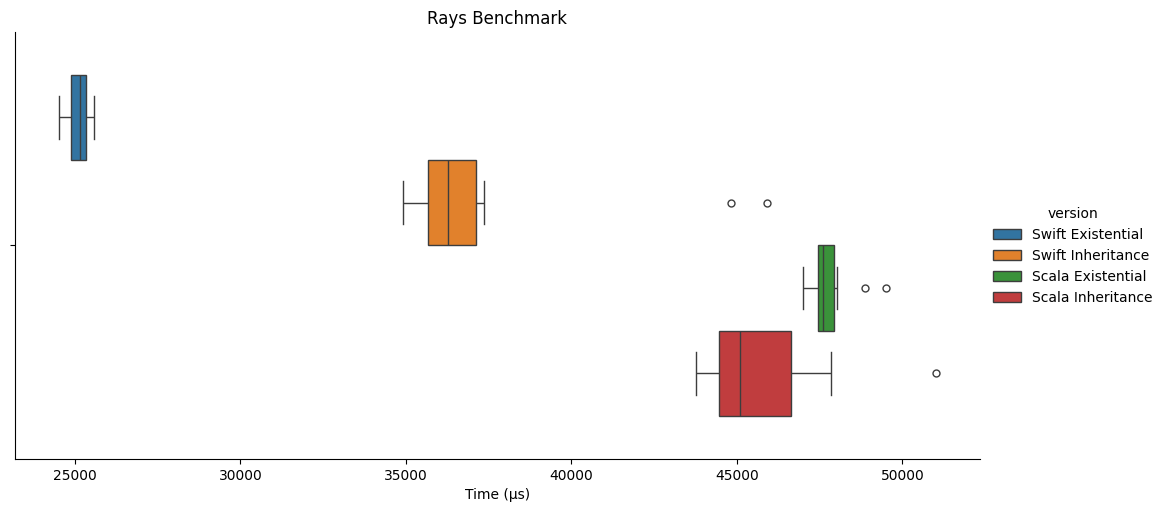

In [10]:
sns.catplot(data=rays, x='Time (μs)', hue='version', kind="box", height=5, aspect=2)
plt.title('Rays Benchmark')
plt.show()

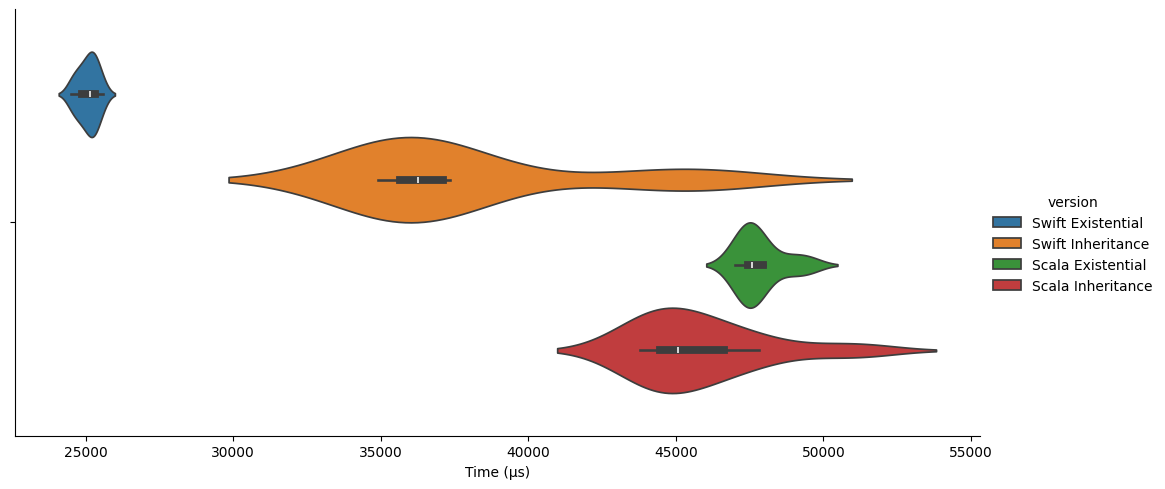

In [11]:
sns.catplot(data=rays, x='Time (μs)', hue='version', kind="violin", height=5, aspect=2, orient='h')

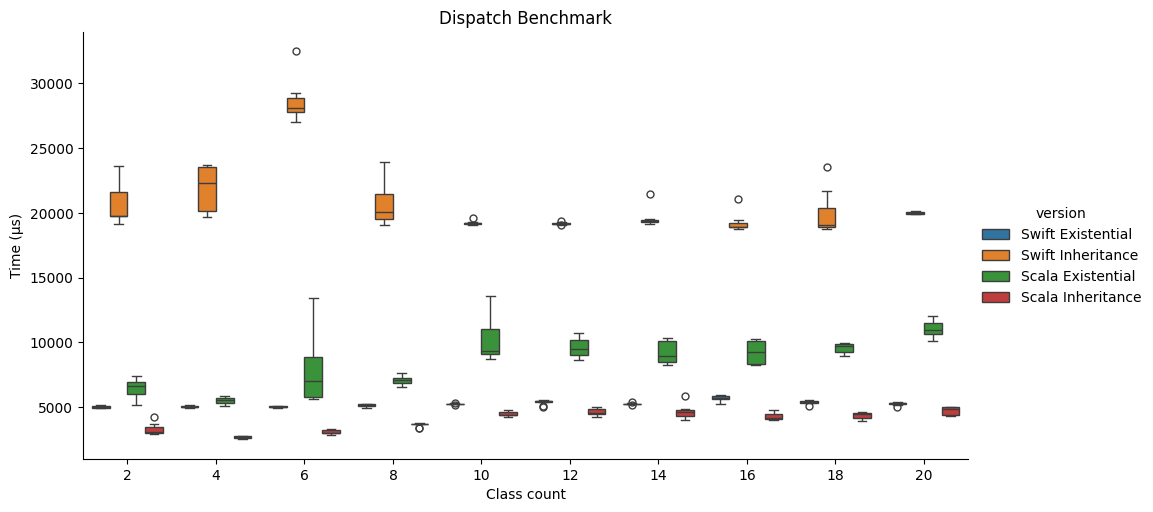

In [12]:
sns.catplot(data=dispatch, x='Class count', y='Time (μs)', hue='version', kind="box", height=5, aspect=2)
plt.title('Dispatch Benchmark')
plt.show()

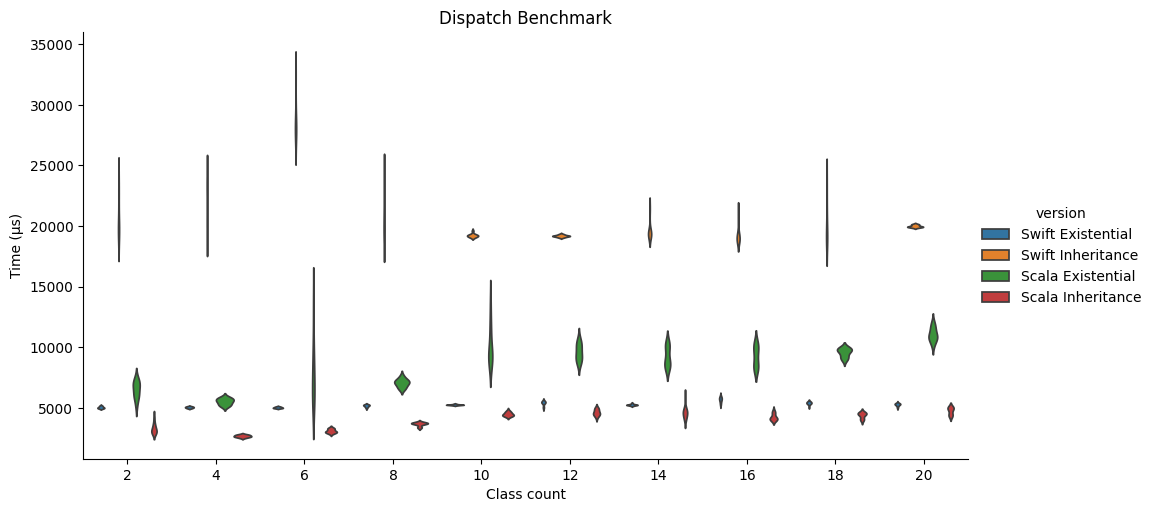

In [13]:
sns.catplot(data=dispatch, x='Class count', y='Time (μs)', hue='version', kind="violin", height=5, aspect=2, inner=None)
plt.title('Dispatch Benchmark')
plt.show()